In [1]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 1. Prepare dataset for ambiguity classification

`Hindi-Test-Filtered` is manually created by dropping the ambiguous images in the `Hindi-Test` set

# 2. Define dataset 

In [2]:
class AmbiguityDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
        
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        ambiguity = image_fn.split(".")[0].split("_")[-1]
        if ambiguity == "amb":
            label = 1
        elif ambiguity == "non-amb":
            label = 0
        else:
            label = -1
        return image, label, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

# 3. Define model

In [3]:
resnet = resnet18(pretrained=True)
for p in resnet.parameters():
    p.requires_grad = False

In [4]:
class Model(nn.Module):
    
    def __init__(self):
        
        super(Model, self).__init__()
        self.dp = nn.Dropout(p=0.5)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn = nn.Sequential(*resnet_modules)
        self.linear1 = nn.Linear(1024, 64)
        self.linear2 = nn.Linear(13*64, 16)
        self.out = nn.Linear(16, 2)
        
        
    def forward(self, batch):
        
        batch = self.cnn(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp(batch)
        # print(batch.size()) # torch.Size([-1, 13, 64])
        
        batch = batch.view(batch_size, -1) 
        # print(batch.size()) # torch.Size([-1, 13*64])
            
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 16])
        
        batch = self.out(batch) # [batch_size, num_classes]
        # print(batch.size()) # torch.Size([-1, 2])
        
        return batch

# 4. Train model

In [64]:
train_batch_size = 16

lr = 0.01
weight_decay = 1e-3
step_size = 300 
gamma = 0.5

num_epochs = 10

In [65]:
trainset = AmbiguityDataset('Ambiguity-Classification-Dataset')
print(len(trainset))
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=os.cpu_count()) 
print(len(train_loader))

5000
313


In [66]:
model = Model()

In [82]:
criterion = nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor([1, 5]))
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [83]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0
    epoch_lr = 0
    
    for X, Y, _ in tqdm(train_loader, desc="Epoch-{}".format(epoch), leave=False):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_last_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_last_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % 1 == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)

Epoch:1    Loss:0.4150610483897189    LR:0.00998402555910536


Epoch:2    Loss:0.32457120261919764    LR:0.00499201277955268


Epoch:3    Loss:0.28856254103608403    LR:0.00249600638977634


Epoch:4    Loss:0.26622252644727024    LR:0.00124800319488817


Epoch:5    Loss:0.24215017030604732    LR:0.000624001597444085


Epoch:6    Loss:0.22922193787444514    LR:0.0003120007987220425


Epoch:7    Loss:0.21374734049847427    LR:0.00015600039936102125


Epoch:8    Loss:0.21268923654438207    LR:7.800019968051062e-05


Epoch:9    Loss:0.21049092545772133    LR:3.900009984025531e-05


Epoch:10    Loss:0.20589588890774563    LR:1.9500049920127656e-05



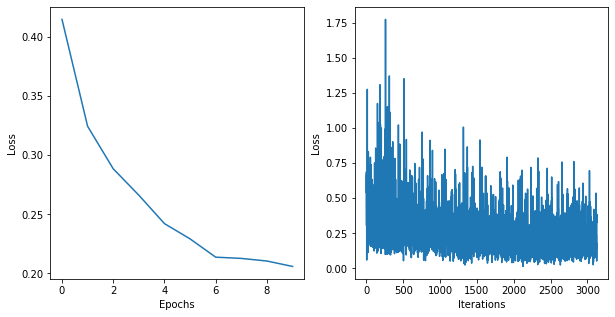

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [85]:
model_path = f'Models/Ambiguity-Classifier.pth'
torch.save(model.state_dict(), model_path)

# 5. Check performance

In [5]:
model_path = f'Models/Ambiguity-Classifier.pth'
model = Model()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
def transform(image):
        
    transform_ops = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

கனக_30_1034_0.jpg
tensor([0.7386, 0.2614], grad_fn=<SelectBackward>)
0.7385960221290588


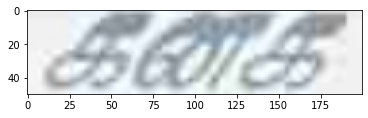

கட்டப்பட்டன_30_2978_0.jpg
tensor([0.5515, 0.4485], grad_fn=<SelectBackward>)
0.5514637231826782


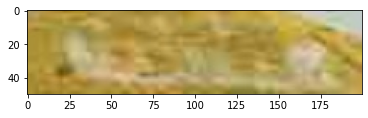

பண்_30_4739_0.jpg
tensor([0.3000, 0.7000], grad_fn=<SelectBackward>)
0.3000296950340271


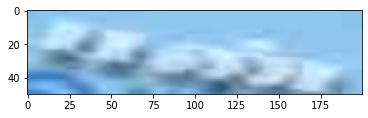

மகனான_30_4318_1.jpg
tensor([0.8305, 0.1695], grad_fn=<SelectBackward>)
0.8304564356803894


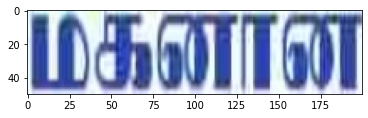

சாயனர்_30_1816_0.jpg
tensor([0.8871, 0.1129], grad_fn=<SelectBackward>)
0.8870578408241272


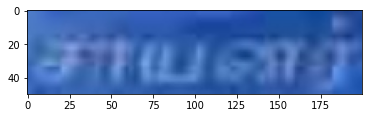

பழ_30_2999_1.jpg
tensor([0.2894, 0.7106], grad_fn=<SelectBackward>)
0.28939294815063477


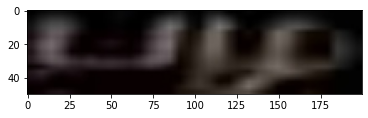

உள்ளது_30_3184_1.jpg
tensor([0.4065, 0.5935], grad_fn=<SelectBackward>)
0.4065447747707367


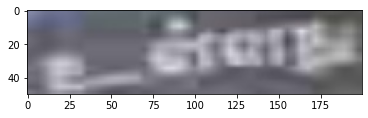

அதாவது_30_4142_2.jpg
tensor([0.9244, 0.0756], grad_fn=<SelectBackward>)
0.9244351387023926


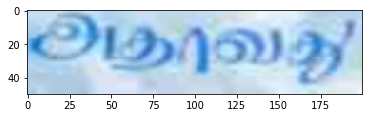

மலாயா_30_1323_2.jpg
tensor([0.1875, 0.8125], grad_fn=<SelectBackward>)
0.18750379979610443


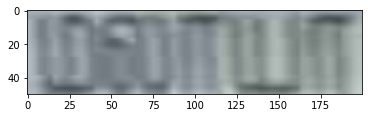

சமர_30_2366_0.jpg
tensor([0.6858, 0.3142], grad_fn=<SelectBackward>)
0.6857684850692749


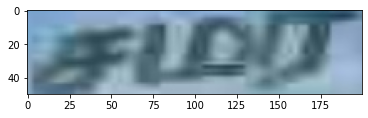

உள்ளனர்_30_3640_1.jpg
tensor([0.1760, 0.8240], grad_fn=<SelectBackward>)
0.17604078352451324


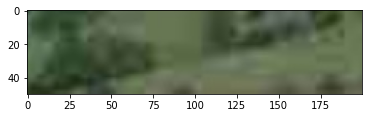

எகா_30_1023_0.jpg
tensor([0.4191, 0.5809], grad_fn=<SelectBackward>)
0.4190596640110016


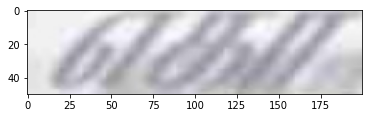

பல_30_4318_0.jpg
tensor([0.0182, 0.9818], grad_fn=<SelectBackward>)
0.018216194584965706


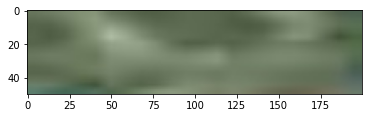

பரிகம்_30_3611_2.jpg
tensor([0.6806, 0.3194], grad_fn=<SelectBackward>)
0.6806254386901855


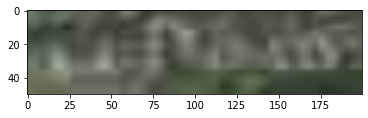

அழகுஆனஅழகான_30_4365_0.jpg
tensor([0.3896, 0.6104], grad_fn=<SelectBackward>)
0.3895835280418396


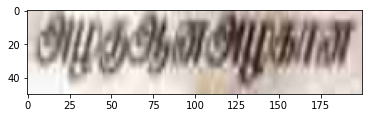

கந்தவர்மன்_30_2663_0.jpg
tensor([0.1254, 0.8746], grad_fn=<SelectBackward>)
0.12539158761501312


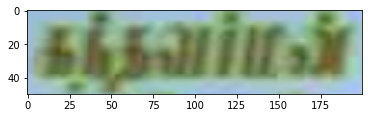

அலி_30_2043_0.jpg
tensor([0.8546, 0.1454], grad_fn=<SelectBackward>)
0.8546271324157715


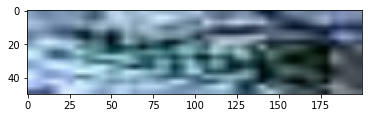

நில_30_1707_0.jpg
tensor([0.1463, 0.8537], grad_fn=<SelectBackward>)
0.14628106355667114


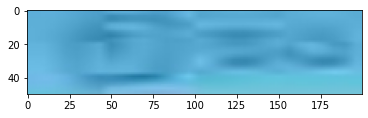

நமது_30_1352_0.jpg
tensor([0.8958, 0.1042], grad_fn=<SelectBackward>)
0.8958287239074707


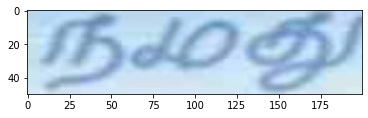

ஆக_30_1727_1.jpg
tensor([0.8011, 0.1989], grad_fn=<SelectBackward>)
0.8010580539703369


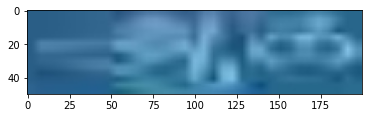

In [7]:
image_dir = "../Data/Tamil/Test"


image_fns = os.listdir(image_dir)
image_fns = np.random.choice(image_fns, 20)

for image_fn in tqdm(image_fns):
    print(image_fn)
    image_fp = os.path.join(image_dir, image_fn)
    image = Image.open(image_fp).convert('RGB')
    image_cp = image.copy()
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    label = F.softmax(model(image), dim=1)[0]
    
    print(label)
    print(label[0].item())
    plt.imshow(image_cp)
    plt.show()

# 6. Make version 2 datasets

In [8]:
language = 'Tamil'

dir_v1 = f'../Data/{language}'
dir_v2 = f'../Data/{language}-V2'

for split in ['Val', 'Test', 'Train']:
    print(f'Processing {split}-Split')
    
    image_dir_v1 = os.path.join(dir_v1, split)
    image_dir_v2 = os.path.join(dir_v2, split)
    os.makedirs(image_dir_v2)
    
    dataset = AmbiguityDataset(image_dir_v1 )
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count()) 
    
    cnt = 0
    for X, Y, FNs in tqdm(data_loader, leave=False):
        X, Y = X.to(device), Y.to(device)
        P = F.softmax(model(X), dim=1)[:, 1] # Ambiguous proability
        mask = (P <= 0.5).detach().numpy()
        FNs_filtered = np.array(FNs)[mask]
        for image_fn in FNs_filtered:
            image_fp_v1 = os.path.join(image_dir_v1, image_fn)
            image_fp_v2 = os.path.join(image_dir_v2, image_fn)
            copyfile(image_fp_v1, image_fp_v2)
        cnt += len(FNs_filtered)
        
    print(f'Filtered {cnt}/{len(os.listdir(image_dir_v1))}')

Processing Val-Split


Filtered 2324/5000
Processing Test-Split


Filtered 2500/5000
Processing Train-Split


Filtered 227822/500000
